# The Cocke, Younger, and Kasami algorithm

To give a thorough example of usage of the library, here we present the CYK parsing algorithm following the approach of [Parsing Techniques](https://dickgrune.com//Books/PTAPG_2nd_Edition/), an eccellent book on parsing by Dick Grune and Ceriel J.H. Jacobs. 

## Hygiene in Context-Free Grammars

First of all, let's start with a series of techniques to clean the *context-free* grammar the algorithm will work on.

### Unreachable, non-productive and undefined symbols

Let's start with the *context-free* grammar $G$ of Figure 2.25 at page 49, we'll be following the flow of Sections 2.9.1, 2.9.2 and 2.9.5.

In [1]:
from liblet import Grammar

G = Grammar.from_string("""
S -> A B | D E
A -> a
B -> b C
C -> c
D -> d F 
E -> e 
F -> f D
""")

We can use the LibLET `@closure` decorator to obtain the *productive* symbols by extending at every round the set `prod` of productive symbols as `{A for A, α in G.P if set(α) <= prod}`, that is taking all the *lefthand* sides of productions whose *righthand* sides are in turn made of productive symbols.

In [2]:
from liblet import closure

def find_productive(G):
    @closure
    def find(prod):
        return prod | {A for A, α in G.P if set(α) <= prod}
    return set(find(G.T))

In [3]:
find_productive(G)

{'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

Similarly, we can obtain the *reachable* symbols by extending at every round the set `reach` of reachable symbols as `union_of(set(α) for A, α in G.P if A in reach)}`, that is taking the union all the *righthand* sides of productions whose *lefthand* sides are in turn reachable.

In [4]:
from liblet import union_of

def find_reachable(G):
    @closure
    def find(reach, G):
        return reach | union_of(set(α) for A, α in G.P if A in reach)
    return find({G.S}, G)   

In [5]:
find_reachable(G)

{'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

To clean the grammar one has first to eliminate the non-productive symbols and the the non-reachable onse (as acting in the reverse order can leave around non-reachable symbols after the first removal).

In [6]:
def remove_unproductive_unreachable(G):
    Gp = G.restrict_to(find_productive(G))
    return Gp.restrict_to(find_reachable(Gp))

In [7]:
remove_unproductive_unreachable(G)

Grammar(N={A, B, C, S}, T={a, b, c}, P=(S -> A B, A -> a, B -> b C, C -> c), S=S)

To remove *undefined* nonterminals is easy, it's enough to collect the ones appearing as *lefthand* side in some production and throw away the others

In [8]:
def remove_undefined(G):
    return G.restrict_to({A for A, α in G.P} | G.T)

Given that `Grammar.from_string` considers nonterminal just the symbols on the *lefthand* sides, to check that the last method works we need to build a grammar in another way:

In [27]:
from liblet import Production

Gu = Grammar({'S', 'T'}, {'s'}, (Production('S', ('s',)),), 'S')
Gu

Grammar(N={S, T}, T={s}, P=(S -> s,), S=S)

In [52]:
remove_undefined(Gu)

Grammar(N={S}, T={s}, P=(S -> s,), S=S)

Observe that undefined symbols are non-productive, hence `remove_unproductive_unreachable` will take implicitly care of them.

## Transforming the Grammar into Chomsky Normal Form

Now that the grammar contains only defined, productive and reachable symbols, to get to the CHomsky normal form we need to take care of ε-rules and unit rules (following Section 4.2.3).

### Elimination of ε-rules

The elimination of ε-rules is performed in a series of consecutive steps, adding new nonterminals and productions.

As an example grammar we use the one of Figure 4.10 at page 120.

In [29]:
G = Grammar.from_string("""
S -> L a M
L -> L M 
L -> ε
M -> M M
M -> ε
""")

Given a rule $A\to ε$ we look for rules of the form $B\to αAβ$ and "inline" the ε-rule by
adding two new rules $B\to αA'β$ and $B\to αβ$ where $A'$ is a new nonterminal; this of course need to be iterated (in a closure) to cope with productions where $A$ appears more than once in the *righthand* side.

In [30]:
@closure
def replace_in_rhs(G, A):
    Ap = A + '’'
    prods = set()
    for B, β in G.P:
        if A in β:
            pos = β.index(A)
            rhs = β[:pos] + β[pos + 1:]
            if len(rhs) == 0: rhs = ('ε', )
            prods.add(Production(B, rhs))
            prods.add(Production(B, β[:pos] + (Ap, ) + β[pos + 1:]))
        else:
            prods.add(Production(B, β))    
    return Grammar(G.N | {Ap}, G.T, prods, G.S)

In [31]:
from liblet import prods2table

Gp = replace_in_rhs(G, 'M')
prods2table(Gp)

The above procedure must be repeated for evey ε-rule, moreover since the process can intruduce new ε-rules, a closure is again needed.

In [32]:
@closure
def inline_ε_rules(G_seen):
    G, seen = G_seen
    for A in G.N - seen:
        if ('ε', ) in G.alternatives(A):
            return replace_in_rhs(G, A), seen | {A}
    return G, seen

In [34]:
Gp, _ = inline_ε_rules((G, set()))
prods2table(Gp)

The *lefthand* sides of the ε rules now are unreachable, but the new "primed" nonterminals must now be defined, using the non-empty *righthand* sides of the one they inlined.

In [35]:
def eliminate_ε_rules(G):
    Gp, _ = inline_ε_rules((G, set()))
    prods = set(Gp.P)
    for Ap in Gp.N - G.N:
        A = Ap[:-1]
        for α in set(Gp.alternatives(A)) - {('ε', )}:
            prods.add(Production(Ap, α))
    return Grammar(Gp.N, Gp.T, prods, Gp.S)

In [36]:
prods2table(eliminate_ε_rules(G))

Removing the unreachable and non-productive rules leads to quite a drastic simplification!

In [37]:
remove_unproductive_unreachable(eliminate_ε_rules(G))

Grammar(N={S}, T={a}, P=(S -> a,), S=S)

### Elimination of unit rules

To see what happens dealing with rules of the form $A\to B$ we'll refer to a more complex grammar, the one of Figure 4.6 at page 112.

In [81]:
G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")
prods2table(G)

We start by applying all the cleaning steps seen so far.

In [82]:
G = remove_unproductive_unreachable(eliminate_ε_rules(G))
prods2table(G)

The elimination of the unit rules is based again on a closure that replaces $A\to B$ 
and $B\to α$ with $A\to α$.

In [83]:
def eliminate_unit_rules(G):
    @closure
    def clean(G_seen):
        G, seen = G_seen
        for P in set(filter(Production.such_that(rhs_len = 1), G.P)) - seen:
            A, (B, ) = P
            if B in G.N:            
                prods = (set(G.P) | {Production(A, α) for α in G.alternatives(B)}) - {P}
                return Grammar(G.N, G.T, prods, G.S), seen | {P}
        return G, seen
    return clean((G, set()))[0]

In [87]:
G = eliminate_unit_rules(G)
prods2table(G)

### The normal form

Two last cases need to be taken care of to get to the CNF. 

First we want to eliminate non-solitary terminals in *lefthand* sides, that is if $A\to αaβ$ where $a\in T$ and $α, β\in N^*$; this is easily solved by introducing a new nonterminal $N_a$ and a new rule $N_a\to a$, replacing the offending $A\to αaβ$ with $A\to αN_aβ$.

In [88]:
def transform_nonsolitary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 1 and set(α) & G.T:
            rhs = []
            for x in α:
                if x in G.T:
                    N = 'N{}'.format(x)
                    prods.add(Production(N, (x, )))
                    rhs.append(N)
                else:
                    rhs.append(x)
            prods.add(Production(A, rhs))
        else:            
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [89]:
G = transform_nonsolitary(G)
prods2table(G)

Finally we need to shorten *righthand* sides longer than 2 symbols. Again that is easily accomplished by introducing new nonterminals and rules.

In [90]:
def make_binary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 2:
            Ai = '{}{}'.format(A, 1)
            prods.add(Production(Ai, α[:2]))
            for i, Xi in enumerate(α[2:-1], 2):
                prods.add(Production('{}{}'.format(A, i), (Ai, Xi)))
                Ai = '{}{}'.format(A, i)
            prods.add(Production(A, (Ai, α[-1])))
        else:
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)


In [91]:
G = make_binary(G)
prods2table(G)

## Parsing

Following the CYK description given in Section 4.2.2 we implement the algoritm by means of a dictionary that, for the key $(i, l)$, records the *lefthand* sides of productions deriving $s_{il}$ that is the substring of the input starting at $i$ and having length $l$.

In [93]:
def cyk(G, INPUT):
    def fill(R, i, l):
        res = set()
        if l == 1:
            for A, (a,) in filter(Production.such_that(rhs_len = 1), G.P): 
                if a == INPUT[i - 1]:
                    res.add(A)
        else:
            for k in range(1, l):
                for A, (B, C) in filter(Production.such_that(rhs_len = 2), G.P):
                    if B in R[(i, k)] and C in R[(i + k, l - k)]:
                        res.add(A)
        return res
    R = {}
    for l in range(1, len(INPUT) + 1):
        for i in range(1, len(INPUT) - l + 2): 
            R[(i, l)] = fill(R, i, l)
    return R

In [98]:
from liblet import cyk2table

INPUT = '32.5e+1'
R = cyk(G, INPUT)
cyk2table(R)

### Getting the derivation from the table

Once the table is filled, it's easy to get a leftmost production by recursing in the table following the same logic used to fill it.

In [99]:
from liblet import show_calls

def get_leftmost_prods(G, R, INPUT):
    @show_calls(True)
    def prods(X, i, l):
        if l == 1:
            return [G.P.index(Production(X, (INPUT[i - 1],)))]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [G.P.index(Production(A, (B, C)))] + prods(B, i, k) + prods(C, i + k, l - k)
    return prods(G.S, 1, len(INPUT))            

In [100]:
prods = get_leftmost_prods(G, R, INPUT)

┌prods('Number', 1, 7)
│┌prods('Number1', 1, 4)
││┌prods('Integer', 1, 2)
│││┌prods('Integer', 1, 1)
│││└─ [4]
│││┌prods('Digit', 2, 1)
│││└─ [9]
││└─ [24, 4, 9]
││┌prods('Fraction', 3, 2)
│││┌prods('N.', 3, 1)
│││└─ [28]
│││┌prods('Integer', 4, 1)
│││└─ [15]
││└─ [5, 28, 15]
│└─ [27, 24, 4, 9, 5, 28, 15]
│┌prods('Scale’', 5, 3)
││┌prods('Scale’1', 5, 2)
│││┌prods('Ne', 5, 1)
│││└─ [16]
│││┌prods('Sign', 6, 1)
│││└─ [19]
││└─ [33, 16, 19]
││┌prods('Integer', 7, 1)
││└─ [17]
│└─ [18, 33, 16, 19, 17]
└─ [11, 27, 24, 4, 9, 5, 28, 15, 18, 33, 16, 19, 17]


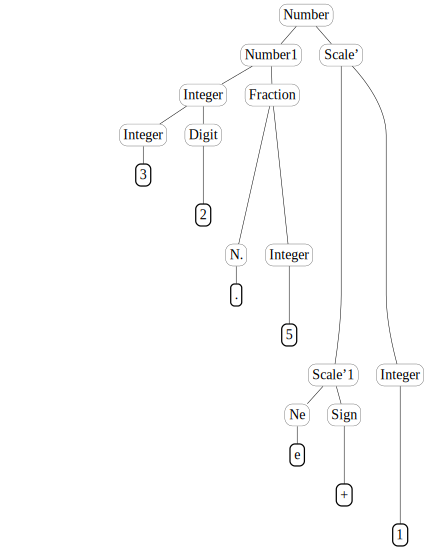

In [101]:
from liblet import Derivation, ProductionGraph

d = Derivation(G)
for step in prods: d = d.leftmost(step)
ProductionGraph(d)